In [1]:
import GPy
from chained_gp.het_loglogistic import HetLogLogistic
from chained_gp.svgp_multi import SVGPMulti
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib
import scipy as sp
from GPy.plotting import Tango
from GPy.plotting.matplot_dep.util import fixed_inputs
from GPy.plotting.matplot_dep.base_plots import gpplot
import matplotlib.ticker as ticker
        
import matplotlib.colors as colors
import matplotlib.cm as cmx
import climin
import sys
import pods
import pylab as pb

import pandas as pd
import numpy as np
from sklearn import cross_validation

# For running R code
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import rpy2.robjects.numpy2ri

matplotlib.use('pgf')
%matplotlib inline

 :0: FutureWarning:IPython widgets are experimental and may change in the future.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning: This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



In [2]:
def optimize(m):
    m.f_kern.fix()
    m.g_kern.fix()
    m.Z.fix()
    #m.constmap.fix()
    [m.optimize('scg', messages=1, max_iters=50) for i in range(3)]
    [m.optimize('lbfgs', messages=1, max_iters=30) for i in range(3)]
    m.f_kern.constrain_positive()
    m.g_kern.constrain_positive()
    m.Z.unconstrain()
    #m.constmap.unfix()
    #m.optimize('lbfgs', messages=1, max_iters=200)
    m.optimize('lbfgs', messages=1, max_iters=500)

 /Users/alansaul/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: VisibleDeprecationWarning:boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1
 /Users/alansaul/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:59: VisibleDeprecationWarning:boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1


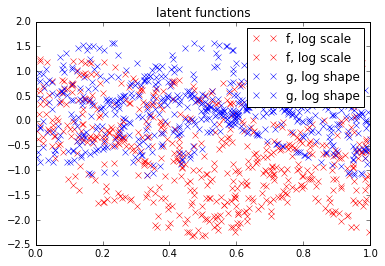

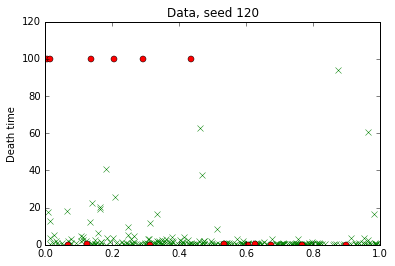

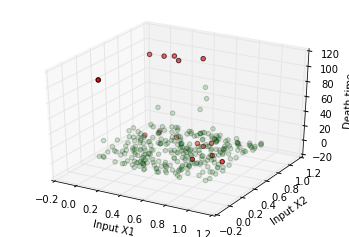

In [3]:
#seed=3
seed=120
N = 300
cens_perc= 3.0
D = 2
np.random.seed(seed)

if D == 1:
    X = np.linspace(0,1,N)[:, None]
else:
    X = np.random.uniform(0, 1, size=(N,D))
kern_f = GPy.kern.RBF(X.shape[1], lengthscale=0.2, name='f_rbf')
kern_f += GPy.kern.White(X.shape[1], variance=1e-5, name='f_white')
kern_g = GPy.kern.RBF(X.shape[1], lengthscale=0.3, name='g_rbf')
#kern_g += GPy.kern.Bias(X.shape[1], variance=5.0, name='g_bias')
kern_g += GPy.kern.White(X.shape[1], variance=1e-5, name='g_white')
kern_g.name = 'g_kern'
kern_f.name = 'f_kern'
#kern_g = GPy.kern.Bias(X.shape[1])
Kf = kern_f.K(X)
Kg = kern_g.K(X)
Lf = GPy.util.linalg.jitchol(Kf)
Lg = GPy.util.linalg.jitchol(Kg)
f = Lf.dot(np.random.randn(X.shape[0])[:, None])
g = Lg.dot(np.random.randn(X.shape[0])[:, None]) - 0.8 # With mean function

#Link function to apply to f and g to ensure positiveness
ef = np.exp(f)
eg = np.exp(g)
#ef = np.log1p(np.exp(f))
#eg = np.log1p(np.exp(g))
Y = np.asarray([sp.stats.fisk.rvs(c=egi, scale=efi) 
                for efi, egi in np.hstack((ef,eg))])[:, None]

#Random censoring
num_censoring = int((cens_perc/100.0)*Y.shape[0])
random_censoring_inds = np.random.permutation(range(Y.shape[0]))[:num_censoring]
censored_times = np.asarray([np.random.uniform(0, Yi) for Yi in Y[random_censoring_inds]])[:, None]
Y[random_censoring_inds] = censored_times


#Right censoring
censor_val = 100.1
right_censor_inds = Y > censor_val
Y[right_censor_inds] = censor_val

censoring = np.zeros_like(Y)
censoring[random_censoring_inds] = 1
censoring[right_censor_inds] = 1
censoring = censoring.astype(bool)

plt.figure()
plt.plot(X,f, 'rx', label='f, log scale')
plt.plot(X,g, 'bx', label='g, log shape')
plt.title('latent functions')
plt.legend()
plt.figure()
plt.plot(X[~censoring], Y[~censoring], 'gx')
plt.plot(X[censoring], Y[censoring], 'ro')
plt.title('Data, seed {}'.format(seed))
plt.ylabel('Death time')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[~censoring[:,0],0], X[~censoring[:,0],1], Y[~censoring], c='g', alpha=0.2)
ax.scatter(X[censoring[:,0],0], X[censoring[:,0],1], Y[censoring], c='r')
ax.set_xlabel('Input X1')
ax.set_ylabel('Input X2')
ax.set_zlabel('Death time')

In [4]:
#Z = X.copy()
Z = X[np.random.permutation(range(X.shape[0]))[:50]]
kern_list = [kern_f.copy(), kern_g.copy()]
het_ll = HetLogLogistic()
g_mean = -1.0
if g_mean is not None:
    g_mean = GPy.mappings.Constant(input_dim=X.shape[1], output_dim=1, value=g_mean)
mean_functions = [None, g_mean]
Y_metadata = {'censored': censoring}

In [5]:
m = SVGPMulti(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=het_ll, 
              mean_functions=mean_functions, Y_metadata=Y_metadata)

In [6]:
m

SVGPMulti.,value,constraints,priors
inducing inputs,"(50, 2)",,
q_u_means,"(50, 2)",,
qf_u_chols,"(1275, 2)",,
f_kern.f_rbf.variance,1.0,+ve,
f_kern.f_rbf.lengthscale,0.2,+ve,
f_kern.f_white.variance,1e-05,+ve,
g_kern.g_rbf.variance,1.0,+ve,
g_kern.g_rbf.lengthscale,0.3,+ve,
g_kern.g_white.variance,1e-05,+ve,
constmap.C,-1.0,,


In [7]:
m.f_kern.f_rbf.lengthscale = 0.4
m.g_kern.g_rbf.lengthscale = 0.4

In [8]:

wanted_f = np.log(np.exp(np.ones((X.shape[0], 1))*Y) - 1)
wanted_g = np.log(np.exp(np.ones((X.shape[0], 1))*4.0) - 1)

Kuuf = m.f_kern.f_rbf.K(m.Z)
Kfu = m.f_kern.f_rbf.K(m.X, m.Z)
Kff = m.f_kern.f_rbf.K(m.X)

Kuug = m.g_kern.g_rbf.K(m.Z)
Kgu = m.g_kern.g_rbf.K(m.X, m.Z)
Kgg = m.g_kern.g_rbf.K(m.X)
q_u_f_mean = Kuuf.dot(sp.linalg.pinv(Kfu)).dot(wanted_f)
q_u_g_mean = Kuug.dot(sp.linalg.pinv(Kgu)).dot(wanted_g)

#wanted_Kff = np.eye(X.shape[0])
#wanted_Kgg = np.eye(X.shape[0])

#q_u_f_chol = GPy.util.linalg.jitchol(Kfu.T.dot(np.linalg.inv(Kff - wanted_Kff)).dot(Kfu))
#q_u_g_chol = GPy.util.linalg.jitchol(Kgu.T.dot(np.linalg.inv(Kgg - wanted_Kgg)).dot(Kgu))

In [9]:
def plot_St(m, Xtest, male=True, ax=None, save=False, num_samples=100,
           fc=None, ec=None):
    #non_fixed_inputs = [dim]
    #inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)
    
    inputs_mat = Xtest.copy()
    
    if male is not None:
        if male:
            inputs_mat[:,1] = -1.0
        else:
            inputs_mat[:,1] = 1.0

    mu_f, covar_f = m._raw_predict(inputs_mat, latent_function_ind=0, full_cov=True)
    mu_g, covar_g = m._raw_predict(inputs_mat, latent_function_ind=1, full_cov=True)
    
    post_f_samples = np.random.multivariate_normal(mu_f.flatten(), covar_f[:,:,0], size=num_samples)
    post_g_samples = np.random.multivariate_normal(mu_g.flatten(), covar_g[:,:,0], size=num_samples)

    post_f_samples = np.exp(post_f_samples)
    post_g_samples = np.exp(post_g_samples)
    t = np.linspace(0, m.Y.max(), 400)[None, :]
    St = 1.0 / (1 + (t / post_f_samples)**post_g_samples)
    mean = np.mean(St,axis=0)[:, None]
    ninety_five = np.percentile(St, 95, axis=0)[:, None]
    five = np.percentile(St, 5, axis=0)[:, None]
    
    if fc and ec:
        fc = fc
        ec = ec
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    gpplot(t.T, mean, five, ninety_five, ax=ax, edgecol=ec, fillcol=fc)

    #for n in range(num_samples):
    #    ax.plot(t.T, St[n,:], c=c, alpha=0.3)
    return ax

In [10]:
def plot_ht(m, Xtest, male=True, ax=None, save=False, num_samples=100, ec=None, fc=None):
    #non_fixed_inputs = [dim]
    #inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)
    
    inputs_mat = Xtest.copy()
    
    if male is not None:
        if male:
            inputs_mat[:,1] = -1.0
        else:
            inputs_mat[:,1] = 1.0

    mu_f, covar_f = m._raw_predict(inputs_mat, latent_function_ind=0, full_cov=True)
    mu_g, covar_g = m._raw_predict(inputs_mat, latent_function_ind=1, full_cov=True)
    
    post_f_samples = np.random.multivariate_normal(mu_f.flatten(), covar_f[:,:,0], size=num_samples)
    post_g_samples = np.random.multivariate_normal(mu_g.flatten(), covar_g[:,:,0], size=num_samples)

    post_f_samples = np.exp(post_f_samples)
    post_g_samples = np.exp(post_g_samples)
    t = np.linspace(0.01, m.Y.max(), 400)[None, :]
    #ft = ( (post_g_samples / post_f_samples)*(t / post_f_samples)**(post_g_samples - 1.0) / 
    #      (1 + (t / post_f_samples)**post_g_samples)**2 ) 
    #St = 1.0 / (1 + (t / post_f_samples)**post_g_samples)
    #ht = ft / St
    alpha = post_f_samples
    beta = post_g_samples
    ht = np.exp(np.log(beta) - np.log(alpha) + (beta - 1.0)*(np.log(t) - np.log(alpha)) - np.log1p((t / alpha)**beta))
    mean = np.mean(ht,axis=0)[:, None]
    ninety_five = np.percentile(ht, 95, axis=0)[:, None]
    five = np.percentile(ht, 5, axis=0)[:, None]
    #print(ht)
    #print((t / alpha)**beta)
    
    if fc and ec:
        fc = fc
        ec = ec
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    gpplot(t.T, mean, five, ninety_five, ax=ax, edgecol=ec, fillcol=fc)

    #for n in range(num_samples):
    #    ax.plot(t.T, St[n,:], c=c, alpha=0.3)
    return ax

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:929: UserWarning:linewidths is ignored by contourf


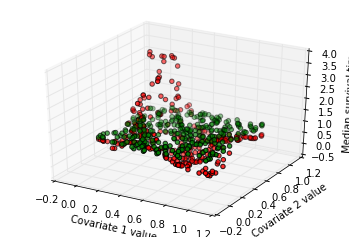

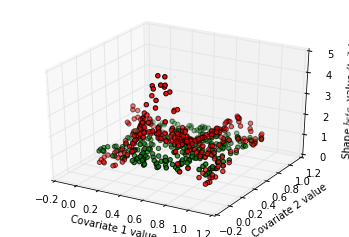

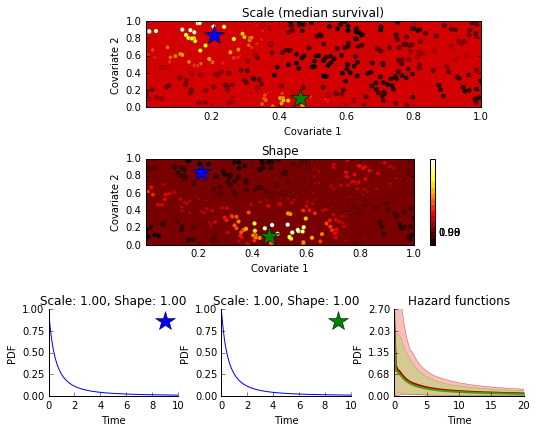

In [11]:
#m.q_u_means[:,0] = np.ones_like(m.q_u_means[:,1])*(0.2) # m.Y[:,0].copy()
#m.q_u_means[:,1] = np.ones_like(m.q_u_means[:,1])*(1.5)
def plot_fit(m, save=False, formatting='eps'):
    mean_f_pred, var_f_pred = m._raw_predict(m.X, 0)
    mean_g_pred, var_g_pred = m._raw_predict(m.X, 1)
    
    #link_f = lambda x: np.log1p(np.exp(x))
    #link_g = lambda x: np.log1p(np.exp(x))

    link_f = lambda x: np.exp(x)
    link_g = lambda x: np.exp(x)
    
    #real_link_f = np.exp(f)
    #real_link_g = np.exp(g)
    real_link_f = ef #np.log1p(np.exp(f))
    real_link_g = eg #np.log1p(np.exp(g))
    
    if X.shape[1] == 1:
        plt.figure()

        plt.plot(m.X, real_link_f, 'rx', label='f, log scale')
        
        plt.plot(m.X, link_f(mean_f_pred), 'bx')
        plt.plot(m.X, link_f(mean_f_pred + 2*np.sqrt(var_f_pred)), 'b--')
        plt.plot(m.X, link_f(mean_f_pred - 2*np.sqrt(var_f_pred)), 'b--')
        plt.xlabel('Covariate value')
        plt.ylabel('Median survival time')
        
        plt.figure()
        plt.plot(m.X, real_link_g, 'bx', label='g, log scale')
        
        plt.plot(m.X, link_g(mean_g_pred), 'gx')
        plt.plot(m.X, link_g(mean_g_pred + 2*np.sqrt(var_g_pred)), 'g--')
        plt.plot(m.X, link_g(mean_g_pred - 2*np.sqrt(var_g_pred)), 'g--')
        plt.xlabel('Covariate value')
        plt.ylabel('Shape $beta$, value (tails)')
    elif X.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], real_link_f, c='r')
        ax.scatter(X[:,0], X[:,1], link_f(mean_f_pred), c='g')
        ax.set_xlabel('Covariate 1 value')
        ax.set_ylabel('Covariate 2 value')
        ax.set_zlabel('Median survival time')
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], real_link_g, c='r')
        ax.scatter(X[:,0], X[:,1], link_g(mean_g_pred), c='g')
        ax.set_xlabel('Covariate 1 value')
        ax.set_ylabel('Covariate 2 value')
        ax.set_zlabel('Shape $beta$, value (tails)')
        
        num_X = 40
        num_Y = 40
        XX, YY = np.meshgrid(np.linspace(m.X[:,0].min(), m.X[:,0].max(), num_X), 
                             np.linspace(m.X[:,1].min(), m.X[:,1].max(), num_Y))
        xa = np.vstack((XX.flatten(), YY.flatten())).T

        mean_f_pred, var_f_pred = m._raw_predict(xa, 0)
        mean_g_pred, var_g_pred = m._raw_predict(xa, 1)
        
        Z_f = mean_f_pred.reshape((num_X, num_Y), order='C')
        Z_g = mean_g_pred.reshape((num_X, num_Y), order='C')
        
        Z_f = link_f(Z_f)
        Z_g = link_g(Z_g)

        biggest_f = np.max([real_link_f.max(), Z_f.max()])
        smallest_f = np.min([real_link_f.min(), Z_f.min()])
        biggest_g = np.max([real_link_g.max(), Z_g.max()])
        smallest_g = np.min([real_link_g.min(), Z_g.min()])
        cm = plt.get_cmap('hot') 
        cNormf  = colors.Normalize(vmin=smallest_f, vmax=biggest_f)
        cNormg  = colors.Normalize(vmin=smallest_g, vmax=biggest_g)
        num_levels = 16
        levels_f = np.linspace(smallest_f, biggest_f, num_levels)
        levels_g = np.linspace(smallest_g, biggest_g, num_levels)
        
        fig, (ax1, ax2) = plt.subplots(2,1)
        #ax1 = fig.add_subplot(111)

        cax1 = ax1.contourf(XX, YY, Z_f, norm=cNormf, linewidths=3.0, cmap=cm, levels=levels_f)  # These are predictions
        ax1.scatter(X[:,0], X[:,1], c=ef, cmap=cm, norm=cNormf, linewidths=0.2)  # These are the data

        if (Z_f.max() - Z_f.min()) > 1e-6:
            cbar1 = plt.colorbar(ax=ax1, ticks=np.round(np.linspace(Z_f.min(), Z_f.max(), 3), 2), mappable=cax1)
        #plt.colorbar(mappable=cax1, ax=ax1)
        ax1.set_xlim(X[:,0].min(), X[:,0].max())
        ax1.set_ylim(X[:,1].min(), X[:,1].max())
        ax1.set_title("Scale (median survival)")
        ax1.set_xlabel('Covariate 1')
        ax1.set_ylabel('Covariate 2')
        
        #fig = plt.figure()
        #ax = fig.add_subplot(111)
        cax2 = ax2.contourf(XX, YY, Z_g, norm=cNormg, linewidths=3.0, cmap=cm, levels=levels_g)  # These are predictions
        ax2.scatter(X[:,0], X[:,1], c=eg, cmap=cm, norm=cNormg, linewidths=0.2)  # These are the data
        ax2.set_xlim(X[:,0].min(), X[:,0].max())
        ax2.set_ylim(X[:,1].min(), X[:,1].max())
        if (Z_g.max() - Z_g.min()) > 1e-6:
            cbar2 = plt.colorbar(ax=ax2, ticks=np.round(np.linspace(Z_g.min(), Z_g.max(), 3), 2), mappable=cax2)
        #plt.colorbar(mappable=cax2, ax=ax2)
        ax2.set_title("Shape")
        ax2.set_xlabel('Covariate 1')
        ax2.set_ylabel('Covariate 2')
        
        fig.subplots_adjust(hspace=0.6)
        
        def plot_fg(fi,fj,gi,gj, axis_loc, stars=False, color='m'):
            fxi = XX[0,fi]
            fyi = YY[fj,0]

            gxi = XX[0,gi]
            gyi = YY[gj,0]

            alpha_1 = Z_f.T[fi,fj]
            beta_1 = Z_g.T[gi,gj]
            transFigure = fig.transFigure.inverted()

            time_range = np.linspace(0.01, 10, 100)
            pdf = np.asarray([sp.stats.fisk.pdf(y, beta_1, scale=alpha_1) for y in time_range])[:, None]

            #First inset
            ax_inset1 = fig.add_axes(axis_loc)

            #ax_inset1 = fig.add_subplot()
            #ax_inset1.a axis_loc)
            ax_inset1.plot(time_range, pdf)
            
            fdata_loc = transFigure.transform(ax1.transData.transform([fxi,fyi]))
            gdata_loc = transFigure.transform(ax2.transData.transform([gxi,gyi]))
            if not stars:
                bottom_left = transFigure.transform(ax_inset1.transData.transform([0,ax_inset1.get_ylim()[0]]))
                bottom_right = transFigure.transform(ax_inset1.transData.transform([0,ax_inset1.get_ylim()[1]]))

                #bottom corner
                line1 = matplotlib.lines.Line2D((fdata_loc[0],bottom_left[0]),(fdata_loc[1],bottom_left[1]),
                                               transform=fig.transFigure)
                line2 = matplotlib.lines.Line2D((gdata_loc[0],bottom_left[0]),(gdata_loc[1],bottom_left[1]),
                                               transform=fig.transFigure)
                #top left corner
                line3 = matplotlib.lines.Line2D((fdata_loc[0],bottom_right[0]),(fdata_loc[1],bottom_right[1]),
                                               transform=fig.transFigure)
                line4 = matplotlib.lines.Line2D((gdata_loc[0],bottom_right[0]),(gdata_loc[1],bottom_right[1]),
                                               transform=fig.transFigure)

                fig.lines.append(line1)
                fig.lines.append(line2)
                fig.lines.append(line3)
                fig.lines.append(line4)
            else:
                #Make some stars as a key
                ax1.plot(fxi, fyi, c=color, marker='*', markersize=20)
                ax2.plot(gxi, gyi, c=color, marker='*', markersize=20)
                ax_inset1.plot(ax_inset1.get_xlim()[1]*0.9, ax_inset1.get_ylim()[1]*0.87, c=color, marker='*', markersize=20)
            ax_inset1.set_xlabel('Time')
            ax_inset1.set_ylabel('PDF')
            ax_inset1.set_title("Scale: {0:.2f}, Shape: {1:0.2f}".format(alpha_1, beta_1))
            ax_inset1.spines['top'].set_visible(False)
            ax_inset1.spines['right'].set_visible(False)
            ax_inset1.yaxis.set_ticks_position('left')
            ax_inset1.xaxis.set_ticks_position('bottom')
            start, end = ax_inset1.get_ylim()
            ax_inset1.yaxis.set_ticks(np.round(np.linspace(start, end, 5),2))
            #ax_inset1.spines['bottom'].set_position(('outward', 10))
            #ax_inset1.spines['left'].set_position(('outward', 10))
            #print color
            #print "Cov1: {}, Cov2: {}".format(fxi, fyi)
            #print "alpha: {}".format(alpha_1)
            #print "beta: {}".format(beta_1)

        #First inset
        #fi = 13
        #fj = 33
        #gi = 8
        #gj = 34
        fi = 8
        fj = 33
        gi = 8
        gj = 33
        plot_fg(fi,fj,gi,gj, [0.5 - 0.4/2.0 - 0.4, -0.4, 0.3, 0.3], stars=True, color='b')
        
        axh = fig.add_axes([0.5 + 0.4/2.0, -0.4, 0.3, 0.3])
        #Also plot the hazard and survival curves
        fxi = XX[0,fi]
        fyi = YY[fj,0]
        fake_X1 = np.array([[fxi, fyi]])
        #axS = plot_St(m, fake_X1, male=None, save=False, ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])
        plot_ht(m, fake_X1, ax=axh, male=None, save=False, ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])
        
        #Second inset
        #fi = 13
        #fj = 18
        #gi = 24
        #gj = 4
        fi = 18
        fj = 4
        gi = 18
        gj = 4
        plot_fg(fi,fj,gi,gj, [0.5 - 0.4/2.0, -0.4, 0.3, 0.3], stars=True, color='g')
                
        fxi = XX[0,fi]
        fyi = YY[fj,0]
        fake_X2 = np.array([[fxi, fyi]])
        
        #plot_St(m, fake_X2, male=None, save=False, ec = Tango.colorsHex['darkGreen'], fc = Tango.colorsHex['lightGreen'], ax=axS)
        plot_ht(m, fake_X2, male=None, save=False, ec = Tango.colorsHex['darkGreen'], fc = Tango.colorsHex['lightGreen'], ax=axh)
        #axS.set_xlim(0,20)
        axh.set_xlim(0,20)
        axh.set_ylim(0,2.7)
        axh.set_xlabel('Time')
        axh.set_ylabel('PDF')
        axh.set_title("Hazard functions")
        axh.spines['top'].set_visible(False)
        axh.spines['right'].set_visible(False)
        axh.yaxis.set_ticks_position('left')
        axh.xaxis.set_ticks_position('bottom')
        start, end = axh.get_ylim()
        axh.yaxis.set_ticks(np.round(np.linspace(start, end, 5),2))
        
        if save:
            if formatting == 'pdf':
                fig.savefig('../images/hetero_toy.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
            elif formatting == 'png':
                fig.savefig('../images/hetero_toy.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
            else:
                fig.savefig('../images/hetero_toy.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
# Before optimization, fit should be poor
_ = plot_fit(m,save=False)

In [12]:
optimize(m)

Running Scaled Conjugate Gradients Code:
  runtime   i    f              |g|        
    00s21  09   4.520099e+12   5.600177e+28 
    00s23  10   1.722599e+12   5.600177e+28 
    00s29  13   6.559659e+11   7.637883e+27 
    00s60  27   1.426398e+10   3.626427e+23 
    01s21  51   7.072273e+07   1.132181e+18 
    01s53  65   5.168172e+06   1.693499e+15 
    01s84  78   2.304876e+06   1.107292e+13 
    02s14  85   1.987353e+06   1.091082e+12 
    02s45  100   1.056188e+05   3.820398e+11 
    02s76  119   1.385706e+04   2.038770e+08 
    03s30  152   3.654156e+03   8.299470e+07 
Runtime:     03s30
Optimization status: maxiter exceeded

Running Scaled Conjugate Gradients Code:
  runtime   i    f              |g|        
    00s15  06   3.649482e+03   1.910468e+07 
    00s59  22   2.190323e+03   4.153497e+12 
Runtime:     00s59
Optimization status: converged - relative stepsize

Running Scaled Conjugate Gradients Code:
  runtime   i    f              |g|        
    00s07  03   2.189630e+03

In [13]:
m.optimize('lbfgs', messages=1, max_iters=6400)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0002   1.075931e+07   3.347578e+19 
    00s25  0006   3.260281e+02   4.474126e+04 
    01s19  0035   3.252281e+02   2.643285e+04 
    03s71  0121   3.227858e+02   4.190161e+04 
    09s97  0369   3.151732e+02   2.453712e+06 
    28s05  0998   2.978202e+02   3.443649e+04 
 01m10s04  2569   2.920890e+02   5.714769e+03 
 02m02s01  4250   2.913601e+02   6.233025e+02 
 02m55s97  6402   2.911307e+02   4.674425e+02 
Runtime:  02m55s97
Optimization status: Maximum number of f evaluations reached



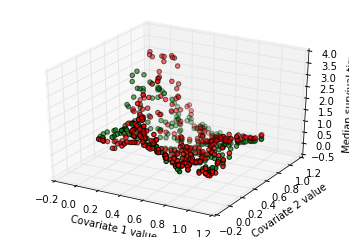

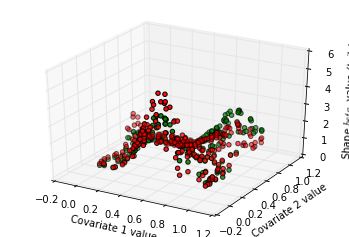

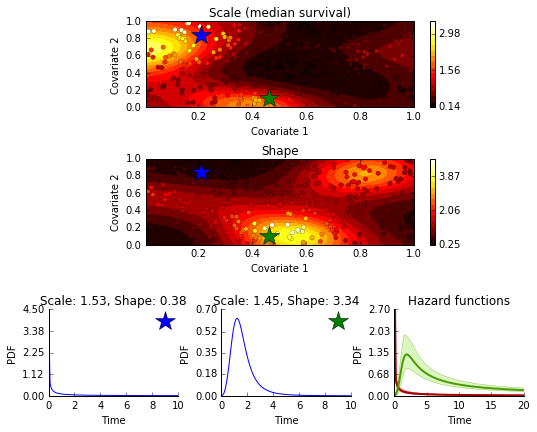

In [14]:
plot_fit(m, save=False, formatting='png')

(0, 20)

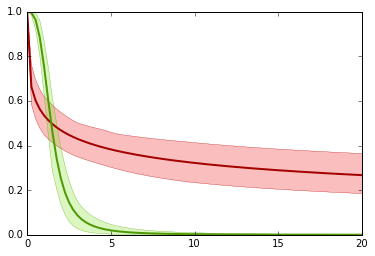

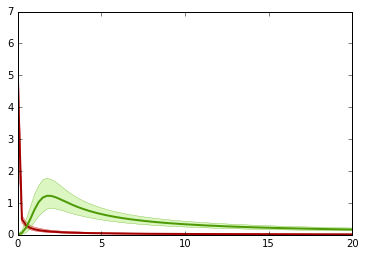

In [15]:
fake_X1 = np.array([[0.208406229691, 0.841887235614]])

axS = plot_St(m, fake_X1, male=None, save=False, ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])
axh = plot_ht(m, fake_X1, male=None, save=False, ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])

fake_X2 = np.array([[0.463493607467, 0.104228882426]])
plot_St(m, fake_X2, male=None, save=False, ec = Tango.colorsHex['darkGreen'], fc = Tango.colorsHex['lightGreen'], ax=axS)
plot_ht(m, fake_X2, male=None, save=False, ec = Tango.colorsHex['darkGreen'], fc = Tango.colorsHex['lightGreen'], ax=axh)
axS.set_xlim(0,20)
axh.set_xlim(0,20)


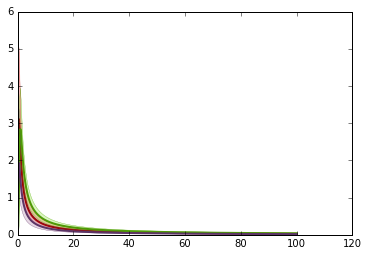

In [16]:
ax = plot_ht(m, m.X[16:17,:].values, male=None, save=False, ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])
plot_ht(m, m.X[17:18,:].values, male=None, save=False, ax=ax, ec = Tango.colorsHex['darkGreen'], fc = Tango.colorsHex['lightGreen'])
plot_ht(m, m.X[3:4,:].values, male=None, save=False, ax=ax, ec = Tango.colorsHex['darkPurple'], fc = Tango.colorsHex['lightPurple'])

In [17]:
opt = climin.Adadelta(m.optimizer_array, m._grads, step_rate=0.2, momentum=0.9)

def callback(i):
    print str(m.log_likelihood()) + " " + str(i['n_iter']), "\r",
    #Stop after 2300 iterations
    if i['n_iter'] > 2300:
        return True
    return False
info = opt.minimize_until(callback)

In [18]:

data = pods.datasets.leukemia()
print data.keys()
N = 2000
inds = np.random.permutation(range(data['X'].shape[0]))[:N]

#IMPORTANT, 1 means censored!!!
lc = 1-data['censoring'][inds, None]
S = data['Y'][inds, None]
Xcovs = data['X'][inds, :]
#Just 'age', 'sex', 'wbc', and 'tpi'
Xcovs = Xcovs[:, 3:7]

print Xcovs.shape
print S.shape
print censoring.shape

[u'files', u'license', u'citation', 'censoring', u'details', u'urls', 'Y', 'X', u'size']
(1043, 4)
(1043, 1)
(300, 1)


In [19]:
#Unskew the WBC
WBC_orig = Xcovs[:,2].copy()
Xcovs[:,2] = np.log10(Xcovs[:,2] + 0.3)
#Normalise continuous values to mean 0, std 1
cond_inds = np.array([0, 2, 3])
Xcovs_means = np.mean(Xcovs, axis=0)
Xcovs_std = np.std(Xcovs, axis=0)
Xcovs[:, cond_inds] = (Xcovs[:, cond_inds] - np.mean(Xcovs[:, cond_inds], axis=0))/np.std(Xcovs[:, cond_inds], axis=0)
S_scale = float(sp.stats.gmean(S))
S = S/S_scale
#S = (S - S.mean())/S.std()
print S.mean()
print S.var()

3.94866009424
44.2116835319


In [20]:
"""
kernel = GPy.kern.RBF(Xcovs.shape[1], variance=1.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/4.0, ARD=True) 
#kernel = GPy.kern.RBF(Xcovs.shape[1], lengthscale=np.ones(Xcovs.shape[1]), ARD=True) 
#kernel += GPy.kern.Linear(Xcovs.shape[1], variances=1.0, ARD=False)
kernel += GPy.kern.Bias(Xcovs.shape[1], variance=0.1)#np.mean(S))
kernel += GPy.kern.White(Xcovs.shape[1], variance=1e-5)

num_inducing = int(Xcovs.shape[0]*0.1)
Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]
beta = 100.0
X_variance = np.ones_like(Xcovs)*1e-12
Y_metadata = {'censored': censoring.copy()}
m = Saul.laplace_bayesian_gplvm.LaplaceBGPLVM(Y=S.copy(), input_dim=S.shape[1], beta=beta, X=Xcovs.copy(), 
                                                    X_variance=X_variance.copy(), init='PCA', num_inducing=Z.shape[0],
                                                 Z=Z, kernel=kernel, likelihood=loglogistic, Y_metadata=Y_metadata)
m.update_model(False)
#m.inducing_inputs.fix()
m.X.fix()
m.kern.white.fix()
m.likelihood.r[:] = 2.0
m.beta_aux.fix()
m.update_model(True)
#m.LogLogisticTheano.r.fix()
"""

"\nkernel = GPy.kern.RBF(Xcovs.shape[1], variance=1.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/4.0, ARD=True) \n#kernel = GPy.kern.RBF(Xcovs.shape[1], lengthscale=np.ones(Xcovs.shape[1]), ARD=True) \n#kernel += GPy.kern.Linear(Xcovs.shape[1], variances=1.0, ARD=False)\nkernel += GPy.kern.Bias(Xcovs.shape[1], variance=0.1)#np.mean(S))\nkernel += GPy.kern.White(Xcovs.shape[1], variance=1e-5)\n\nnum_inducing = int(Xcovs.shape[0]*0.1)\nZ = np.random.permutation(Xcovs.copy())[:num_inducing, :]\nbeta = 100.0\nX_variance = np.ones_like(Xcovs)*1e-12\nY_metadata = {'censored': censoring.copy()}\nm = Saul.laplace_bayesian_gplvm.LaplaceBGPLVM(Y=S.copy(), input_dim=S.shape[1], beta=beta, X=Xcovs.copy(), \n                                                    X_variance=X_variance.copy(), init='PCA', num_inducing=Z.shape[0],\n                                                 Z=Z, kernel=kernel, likelihood=loglogistic, Y_metadata=Y_metadata)\nm.update_model(False)\n#m.inducing_inputs.fix()\

In [21]:
def make_model(Xcovs, S, censor):
    #Z = X.copy()
    kern_f = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')

    kern_g = GPy.kern.RBF(X.shape[1], name='g_rbf')
    kern_g += GPy.kern.Bias(X.shape[1], variance=1.0, name='g_bias')
    kern_g += GPy.kern.White(X.shape[1], variance=1e-5, name='g_white')
    kern_g.name = 'g_kern'
    kern_f.name = 'f_kern'
    kern_list = [kern_f.copy(), kern_g.copy()]
    het_ll = HetLogLogistic()
    g_mean = None# 1.0
    if g_mean is not None:
        g_mean = GPy.mappings.Constant(input_dim=Xcovs.shape[1], output_dim=1, value=g_mean)
    mean_functions = [None, g_mean]
    
    Y_metadata = {'censored': censor}
    num_inducing = int(Xcovs.shape[0]*0.1)
    Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]
    
    #Do some inference and test with calculate_error
    lm = SVGPMulti(X=Xcovs, Y=S, Z=Z, kern_list=kern_list, likelihood=het_ll, 
          mean_functions=mean_functions, Y_metadata=Y_metadata)
    return lm

In [22]:
lm = make_model(Xcovs, S, lc)
#lm.constmap.C[:] = -2.3

In [23]:
lm.optimize('bfgs', messages=1, max_iters=1300)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s89  010   3.129970e+04   8.956855e+08 
    01s55  019   2.455793e+03   8.806474e+04 
    02s59  031   1.726340e+03   1.571857e+03 
    09s68  099   1.663238e+03   1.568051e+02 
    14s26  158   1.658440e+03   1.204485e+02 
    31s05  302   1.655657e+03   1.199448e+02 
Runtime:     31s05
Optimization status: Maximum number of f evaluations reached



In [24]:
def plot_f(m,dim, male=True, ax=None, save=False, rescale=True,
          fc=None, ec=None, formatting='pdf'):

    non_fixed_inputs = [dim]
    #inputs = fixed_inputs(m, non_fixed_inputs, 'median')
    inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)

    if male is not None:
        if male:
            inputs_mat[:,1] = -1.0
        else:
            inputs_mat[:,1] = 1.0

    mu, var = m._raw_predict(inputs_mat)

    two_std = 2*np.sqrt(var)
    #Scale back into 'days' scale
    mean = np.exp(mu)
    five = np.exp(mu - two_std)
    nf = np.exp(mu + two_std)
    x = inputs_mat[:, non_fixed_inputs]
    if rescale:
        #Rescale x back to standard range
        mean = mean*S_scale
        five = five*S_scale
        nf = nf*S_scale
        x = x*Xcovs_std[non_fixed_inputs] + Xcovs_means[non_fixed_inputs]
        #if dim == 2:
        #    x = 10**x - 0.3
        
    #Sort for plotting
    s = np.argsort(x, axis=0)
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    if fc and ec:
        fc = fc
        ec = ec
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
    gpplot(x[s], mean[s], five[s], nf[s], ax=ax, edgecol=ec, fillcol=fc)
    ax.semilogy()
    #ax.set_ylim(0, nf.max())
    ax.set_xlim(x.min(), x.max())

    if dim == 0:
        xlabel = 'Age'
    elif dim == 2:
        xlabel = 'log10(WBC + 0.3)'
    elif dim == 3:
        xlabel = 'Town deprevation index'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Expected lifetime (days)')

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if save:
        if formatting == 'pdf':
            fig.savefig('Figures/non-linear-dose-response.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
        elif formatting == 'png':
            fig.savefig('Figures/non-linear-dose-response.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
        if formatting == 'eps':
            fig.savefig('Figures/non-linear-dose-response.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
    return ax

In [25]:
def plot_f_2d(m, dim1, dim2, male=True, ax=None, save=False, rescale=True,
              fc=None, ec=None, cmap=None, formatting='pdf'):
    #non_fixed_inputs = [dim1, dim2]
    #inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)
    others = list(set(range(m.X.shape[1])) - set([dim1, dim2]))
    num_X = 40
    inputs_mat = np.zeros((num_X, m.X.shape[1]))
    inputs_mat[:,dim1] = np.linspace(m.X[:,dim1].min(), m.X[:,dim1].max(), num_X)
    inputs_mat[:,dim2] = np.linspace(m.X[:,dim2].min(), m.X[:,dim2].max(), num_X)

    XX, YY = np.meshgrid(inputs_mat[:,dim1], inputs_mat[:,dim2])
    
    final_inputs_mat = np.zeros((XX.flatten().shape[0], m.X.shape[1]))
    final_inputs_mat[:, dim1] = XX.flatten()
    final_inputs_mat[:, dim2] = YY.flatten()
    final_inputs_mat[:, others] = np.median(m.X.values, axis=0)[others]
    
    if male is not None:
        if male:
            final_inputs_mat[:,1] = -1.0
        else:
            final_inputs_mat[:,1] = 1.0
        
    mean_f_pred, var_f_pred = m._raw_predict(final_inputs_mat)  # mean_f_pred, var_f_pred
    
    mu = mean_f_pred
    var = var_f_pred
    
    two_std = 2*np.sqrt(var)
    #Scale back into 'days' scale
    mean = np.exp(mu)
    five = np.exp(mu - two_std)
    nf = np.exp(mu + two_std)
    if rescale:
        #Rescale x back to standard range
        mean = mean*S_scale
        five = five*S_scale
        nf = nf*S_scale
        if dim1 == 2:
            pass
            #XX = 10**XX - 0.3
        else:
            XX = XX*Xcovs_std[dim1] + Xcovs_means[dim1]

        if dim2 == 2:
            pass
            #YY = 10**YY - 0.3
        else:
            YY = YY*Xcovs_std[dim2] + Xcovs_means[dim2]
        
    #Sort for plotting
    if ax is None:
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if fc and ec and cmap:
        fc = fc
        ec = ec
        cmap = cmap
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
            cmap = matplotlib.cm.Greens_r
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
            cmap = matplotlib.cm.Blues_r

    #gpplot(x[s], mean[s], five[s], nf[s], ax=ax, edgecol=ec, fillcol=fc)
    #ax.semilogy()
    #ax.set_ylim(0, nf.max())
    #ax.set_xlim(x.min(), x.max())
    Z_f = mean.reshape((num_X, num_X), order='C')
    ax.plot_surface(XX, YY, Z_f, rstride=1, cstride=1, cmap=cmap, lw=0.2, alpha=1.0)

    if dim1 == 0:
        xlabel = 'Age'
    elif dim1 == 2:
        xlabel = 'log10(WBC + 0.3)'
    elif dim1 == 3:
        xlabel = 'Town deprevation index'
    if dim2 == 0:
        ylabel = 'Age'
    elif dim2 == 2:
        ylabel = 'log10(WBC + 0.3)'
    elif dim2 == 3:
        ylabel = 'Town deprevation index'
        
    ax.set_xlabel("\n"+xlabel)
    ax.set_ylabel("\n"+ylabel)
    ax.set_zlabel("\n"+'Expected lifetime (days)')
    ax.view_init(elev=30., azim=34)
    ax.set_yticks(np.linspace(YY.min(), YY.max(), 6).round(1))
    ax.set_xticks(np.arange(0, 100, 10))
    
    #ax.set_yticklabels(np.linspace(YY.min(), YY.max(), 4))#,#rotation=-15,
                   #verticalalignment='baseline',
                   #horizontalalignment='left')
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.yaxis.set_ticks_position('left')
    #ax.xaxis.set_ticks_position('bottom')

    ax.patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    if save:
        if formatting == 'pdf':
            fig.savefig('Figures/2dnon-linear-dose-response.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
        elif formatting == 'png':
            fig.savefig('Figures/2dnon-linear-dose-response.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
        if formatting == 'eps':
            fig.savefig('Figures/2dnon-linear-dose-response.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
    return ax

In [26]:
def plot_f_g(m,dim, male=None, ax=None, save=False, rescale=True,
             fc=None, ec=None, formatting='pdf'):
    non_fixed_inputs = [dim]
    inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)

    if male is not None:
        if male:
            inputs_mat[:,1] = -1.0
        else:
            inputs_mat[:,1] = 1.0

    mu_f, var_f = m._raw_predict(inputs_mat, latent_function_ind=0)
    mu_g, var_g = m._raw_predict(inputs_mat, latent_function_ind=1)
    
    #two_std isnt important here, make it 96th percentile of loglogistic
    two_std = 2*np.sqrt(np.exp(mu_g))
    #Scale back into 'days' scale
    mean = np.exp(mu_f)
    five = np.exp(mu_f - two_std)
    nf = np.exp(mu_f + two_std)
    x = inputs_mat[:, non_fixed_inputs]
    #Rescale x back to standard range
    if rescale:
        mean = mean*S_scale
        five = five*S_scale
        nf = five*S_scale
        x = x*Xcovs_std[non_fixed_inputs] + Xcovs_means[non_fixed_inputs]

        #if dim == 2:
        #    x = 10**x - 0.3
        
    #Sort for plotting
    s = np.argsort(x, axis=0)
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    if fc and ec:
        fc = fc
        ec = ec
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
    
    gpplot(x[s], mean[s], five[s], nf[s], ax=ax, edgecol=ec, fillcol=fc)
    ax.semilogy()
    #ax.set_ylim(0, nf.max())
    ax.set_xlim(x.min(), x.max())

    if dim == 0:
        xlabel = 'Age'
    elif dim == 2:
        xlabel = 'log10(WBC + 0.3)'
    elif dim == 3:
        xlabel = 'Town deprevation index'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Expected lifetime (days)')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if save:
        if formatting == 'pdf':
            fig.savefig('Figures/fgnon-linear-dose-response.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
        elif formatting == 'png':
            fig.savefig('Figures/fgnon-linear-dose-response.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
        if formatting == 'eps':
            fig.savefig('Figures/fgnon-linear-dose-response.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
    return ax

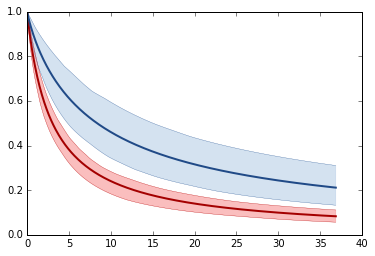

In [27]:
ax = plot_St(lm, lm.X[10:11,:].values, male=False, save=False, 
             ec = Tango.colorsHex['darkRed'], fc = Tango.colorsHex['lightRed'])
plot_St(lm, lm.X[1:2,:].values, male=False, save=False, ax=ax)

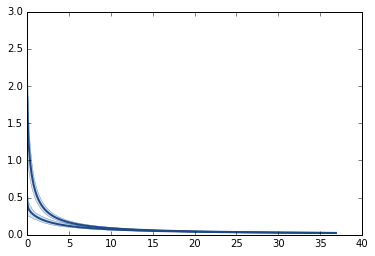

In [28]:
ax = plot_ht(lm, lm.X[10:11,:].values, male=None, save=False)
plot_ht(lm, lm.X[38:39,:].values, male=False, save=False, ax=ax)

In [29]:
lm

SVGPMulti.,value,constraints,priors
inducing inputs,"(104, 4)",,
q_u_means,"(104, 2)",,
qf_u_chols,"(5460, 2)",,
f_kern.f_rbf.variance,4.02681704372,+ve,
f_kern.f_rbf.lengthscale,"(4,)",+ve,
f_kern.f_bias.variance,0.0684245204964,+ve,
f_kern.f_white.variance,9.81957402902e-06,+ve,
g_kern.g_rbf.variance,0.00806911434441,+ve,
g_kern.g_rbf.lengthscale,0.237324884247,+ve,
g_kern.g_bias.variance,0.0954720547928,+ve,


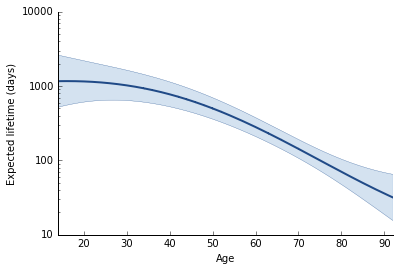

In [30]:
ax = plot_f(lm, 0, male=False, save=False, formatting='eps')

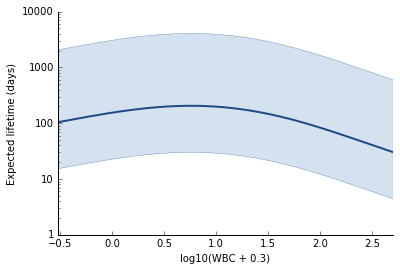

In [31]:
ax = plot_f_g(lm, 2, male=False, save=False)

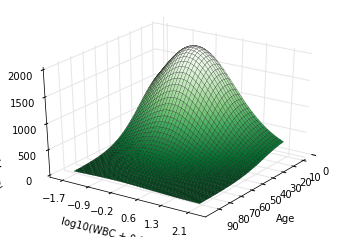

In [32]:
ax = plot_f_2d(lm, 0, 2, male=True, save=False, formatting='eps')
#plot_f_2d(lm, 0, 2, male=False, ax=ax)

In [33]:
lm

SVGPMulti.,value,constraints,priors
inducing inputs,"(104, 4)",,
q_u_means,"(104, 2)",,
qf_u_chols,"(5460, 2)",,
f_kern.f_rbf.variance,4.02681704372,+ve,
f_kern.f_rbf.lengthscale,"(4,)",+ve,
f_kern.f_bias.variance,0.0684245204964,+ve,
f_kern.f_white.variance,9.81957402902e-06,+ve,
g_kern.g_rbf.variance,0.00806911434441,+ve,
g_kern.g_rbf.lengthscale,0.237324884247,+ve,
g_kern.g_bias.variance,0.0954720547928,+ve,
